<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [2]:
%pip install statstests

In [3]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [4]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features_60min.parquet','/content/datasets/')

Mounted at /content/drive


In [5]:
df = pd.read_parquet('/content/datasets/transactions_features_60min.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [6]:
df.head()

,date_window,transactions,frauds,mean_amount,std_amount,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,...,category_technology_telecommunications,category_health_medical,category_professional_business_services,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,2010-01-01 00:00:00,26,0,23.964231,38.352274,53.384615,14.721622,61980.192308,735.192308,60.334414,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1,2010-01-01 01:00:00,22,0,48.329545,68.191605,54.909091,13.738750,58917.545455,737.454545,56.607864,...,0.05,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,2010-01-01 02:00:00,25,0,41.120400,51.744504,51.680000,17.199128,73585.080000,726.120000,53.216006,...,0.00,0.04,0.04,0.04,0.04,0.00,0.0,0.0,0.0,0.0
3,2010-01-01 03:00:00,21,0,34.030952,63.774164,52.333333,16.103830,47075.000000,711.285714,64.968564,...,0.19,0.05,0.00,0.00,0.05,0.00,0.0,0.0,0.0,0.0
4,2010-01-01 04:00:00,16,0,37.382500,45.371877,54.687500,13.636807,54884.312500,678.375000,74.337855,...,0.00,0.06,0.00,0.00,0.00,0.06,0.0,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86151 entries, 0 to 86150
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              86151 non-null  datetime64[us]
 1   transactions                             86151 non-null  uint32        
 2   frauds                                   86151 non-null  int32         
 3   mean_amount                              86151 non-null  float64       
 4   std_amount                               86140 non-null  float64       
 5   mean_current_age                         86151 non-null  float64       
 6   std_current_age                          86140 non-null  float64       
 7   mean_total_debt                          86151 non-null  float64       
 8   mean_credit_score                        86151 non-null  float64       
 9   std_credit_score                       

In [8]:
df.describe()

,date_window,transactions,frauds,mean_amount,std_amount,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,...,category_technology_telecommunications,category_health_medical,category_professional_business_services,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
count,86151,86151.000000,86151.000000,86151.000000,86140.000000,86151.000000,86140.000000,86151.000000,86151.000000,86140.000000,...,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000
mean,2014-12-01 15:27:28.250165,103.480668,0.154752,46.634533,79.750805,53.812155,15.487478,58038.649450,714.192859,64.422622,...,0.041642,0.064984,0.008595,0.005773,0.008329,0.004772,0.000520,0.028329,0.013491,0.008181
min,2010-01-01 00:00:00,1.000000,0.000000,-422.000000,15.491699,26.000000,4.041452,686.000000,651.000000,14.977390,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-17 05:30:00,33.000000,0.000000,37.240395,56.333706,52.581116,14.653634,53740.419963,708.489606,60.242946,...,0.010000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
50%,2014-12-01 15:00:00,94.000000,0.000000,44.672475,70.898425,53.891566,15.585020,57966.699422,714.242424,64.904563,...,0.030000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.010000
75%,2017-05-17 13:30:00,164.000000,0.000000,52.975841,94.317958,55.113333,16.418038,62090.871238,719.677799,69.360788,...,0.050000,0.080000,0.010000,0.000000,0.010000,0.010000,0.000000,0.040000,0.010000,0.010000
max,2019-10-31 23:00:00,245.000000,9.000000,1501.560000,1323.626113,82.000000,26.279817,124771.000000,788.000000,108.086925,...,0.500000,0.420000,0.270000,1.000000,0.250000,0.200000,0.670000,1.000000,1.000000,0.170000
std,NaN,62.285940,0.594059,17.069769,35.100653,2.257235,1.547826,7068.129881,9.602254,8.342741,...,0.044720,0.036345,0.016578,0.016522,0.013366,0.010354,0.003729,0.026552,0.025988,0.010502


In [9]:
df['frauds'].value_counts(normalize=True)

,proportion
frauds,
0,0.911562
1,0.048612
2,0.024178
3,0.009298
4,0.003726
5,0.001463
6,0.000731
7,0.000209
8,0.000163


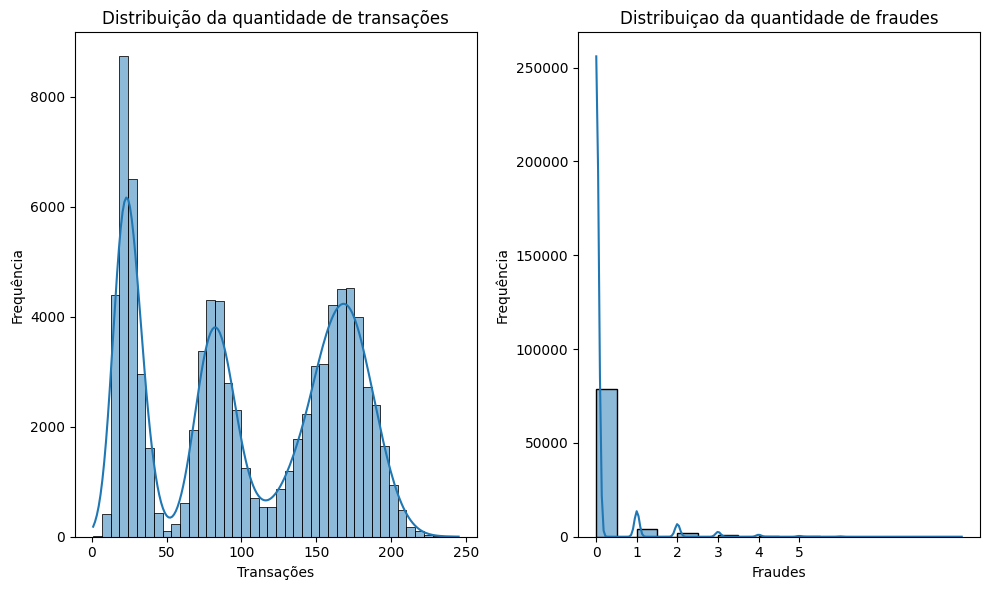

In [10]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title('Distribuição da quantidade de transações')
sns.histplot(df['transactions'], kde=True)
plt.xlabel('Transações')
plt.ylabel('Frequência')

plt.subplot(122)
plt.title('Distribuiçao da quantidade de fraudes')
sns.histplot(df['frauds'], kde=True)
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, 6, 1))

plt.tight_layout()
plt.show()

## Implementação de Modelos

### Função de Comparação

In [11]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [12]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [13]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [14]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.154752,0.352906


Há indícios de superdispersão.

In [15]:
all_features = df.drop(columns=['frauds', 'date_window']).columns.to_list()
all_features[0:3]

['transactions', 'mean_amount', 'std_amount']

In [16]:
features_completa_formula = 'frauds ~ ' + ' + '.join(all_features)
features_completa_formula

'frauds ~ transactions + mean_amount + std_amount + mean_current_age + std_current_age + mean_total_debt + mean_credit_score + std_credit_score + mean_num_credit_cards + std_num_credit_cards + skew_num_credit_cards + kurtosis_num_credit_cards + mean_credit_limit + gender_female + card_brand_amex + card_brand_discover + card_type_debit_prepaid + has_chip_no + category_food_beverage + category_retail_general_department + category_financial_insurance + category_retail_specialty + category_transportation_logistics + category_government_utilities + category_arts_entertainment_recreation + category_technology_telecommunications + category_health_medical + category_professional_business_services + category_travel_hospitality + category_retail_clothing_accessories + category_sports_recreation + category_construction_contractors + category_retail_home_garden + category_manufacturing_industrial + category_personal_services'

In [17]:
modelo_poison_simple = smf.glm(formula='frauds ~ transactions', data=df, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86151
Model:                            GLM   Df Residuals:                    86149
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38269.
Date:                Tue, 27 May 2025   Deviance:                       58459.
Time:                        22:32:23   Pearson chi2:                 1.61e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1142
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.1217      0.032   -129.039      0.000      -4.184      -4.059
transactions     0.0170      0.000     86.113      0.000       0.017       0.017
================================================================================
"""

Observações do modelo simples

* Intercepto e variavel `transactions` são estatisticamente significantes
* O Log-Likelihood é alto
* Pseudo R-Squ. (CS) indique que apenas a variavel `transaction` explica menos que 3% da variância na contagem de fraudes.



In [18]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=df, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86104
Model Family:                 Poisson   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37800.
Date:                Tue, 27 May 2025   Deviance:                       57524.
Time:                        22:32:25   Pearson chi2:                 1.65e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1237
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.6058      1.283      1.251      0.211      -0.909       4.121
transactions                                0.0186      0.000     65.217      0.000       0.018       0.019
mean_amount                                 0.0067      0.001     10.056      0.000       0.005       0.008
std_amount                                  0.0005      0.000      1.336      0.181      -0.000       0.001
mean_current_age                            0.0155      0.007      2.263      0.024       0.002       0.029
std_current_age                            -0.0493      0.009     -5.357      0.000      -0.067      -0.031
mean_total_debt                          -4.62e-06   1.96e-06     -2.358      0.018   -8.46e-06   -7.81e-07
mean_credit_score                          -0.0106      0.001     -7.314      0.000      -0.013      -0.008
std_credit_score                           -0.0072      0.002     -4.217      0.000      -0.011      -0.004
mean_num_credit_cards                       0.3537      0.067      5.258      0.000       0.222       0.486
std_num_credit_cards                       -0.2147      0.098     -2.192      0.028      -0.407      -0.023
skew_num_credit_cards                       0.3534      0.066      5.356      0.000       0.224       0.483
kurtosis_num_credit_cards                  -0.0219      0.033     -0.658      0.510      -0.087       0.043
mean_credit_limit                        2.899e-06   8.45e-06      0.343      0.732   -1.37e-05    1.95e-05
gender_female                               1.4223      0.174      8.179      0.000       1.082       1.763
card_brand_amex                            -1.5764      0.365     -4.316      0.000      -2.292      -0.861
card_brand_discover                         2.0381      0.545      3.739      0.000       0.970       3.106
card_type_debit_prepaid                     1.1704      0.357      3.279      0.001       0.471       1.870
has_chip_no                                 0.2237      0.292      0.766      0.443      -0.348       0.796
category_food_beverage                      0.1686      0.637      0.265      0.791      -1.079       1.416
category_retail_general_department          3.2153      0.674      4.768      0.000       1.894       4.537
category_financial_insurance                1.0637      0.749      1.419      0.156      -0.405       2.533
category_retail_specialty                  -1.4453      0.758     -1.907      0.056      -2.930       0.040
category_transportation_logistics          -0.9496      0.643     -1.477      0.140      -2.210       0.310
category_government_utilities              -3.2703      0.791     -4.135      0.000      -4.820      -1.720
category_arts_entertainment_recreation     -3.1629      0.8

In [19]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.007      
Dependent Variable:     ystar            AIC:                         631658.3735
Date:                   2025-05-27 22:32 BIC:                         631667.7373
No. Observations:       86140            Log-Likelihood:              -3.1583e+05
Df Model:               1                F-statistic:                 644.5      
Df Residuals:           86139            Prob (F-statistic):          1.18e-141  
R-squared (uncentered): 0.007            Scale:                       89.572     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.8018         0.1498       25.3866       0.0000       3.5082    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

In [20]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('mean_current_age') + Q('std_current_age') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_food_beverage') + Q('category_retail_general_department') + Q('category_financial_insurance') + Q('category_retail_specialty') + Q('category_transportation_logistics') + Q('category_government_utilities') + Q('category_arts_entertainment_recreation') + Q('category_technology_telecommunications') + Q('category_health_medical') + Q('category_professional_business_services') + Q('category_travel_hospitality') + Q('category_retail_clothing_accessories') + Q('category_sports_recreation') + Q(

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86113
Model Family:                 Poisson   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37802.
Date:                Tue, 27 May 2025   Deviance:                       57528.
Time:                        22:32:41   Pearson chi2:                 1.65e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1237
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        1.8660      1.119      1.668      0.095      -0.326       4.058
Q('transactions')                                0.0187      0.000     72.133      0.000       0.018       0.019
Q('mean_amount')                                 0.0072      0.000     18.004      0.000       0.006       0.008
Q('mean_current_age')                            0.0153      0.007      2.234      0.025       0.002       0.029
Q('std_current_age')                            -0.0497      0.009     -5.414      0.000      -0.068      -0.032
Q('mean_total_debt')                         -4.552e-06   1.84e-06     -2.479      0.013   -8.15e-06   -9.53e-07
Q('mean_credit_score')                          -0.0106      0.001     -7.361      0.000      -0.013      -0.008
Q('std_credit_score')                           -0.0073      0.002     -4.241      0.000      -0.011      -0.004
Q('mean_num_credit_cards')                       0.3494      0.066      5.277      0.000       0.220       0.479
Q('std_num_credit_cards')                       -0.1875      0.088     -2.120      0.034      -0.361      -0.014
Q('skew_num_credit_cards')                       0.3224      0.046      6.988      0.000       0.232       0.413
Q('gender_female')                               1.4133      0.173      8.180      0.000       1.075       1.752
Q('card_brand_amex')                            -1.5922      0.361     -4.407      0.000      -2.300      -0.884
Q('card_brand_discover')                         2.0310      0.543      3.740      0.000       0.967       3.095
Q('card_type_debit_prepaid')                     1.1543      0.331      3.488      0.000       0.506       1.803
Q('category_retail_general_department')          3.0079      0.245     12.275      0.000       2.528       3.488
Q('category_financial_insurance')                0.9077      0.432      2.101      0.036       0.061       1.754
Q('category_retail_specialty')                  -1.5436      0.510     -3.025      0.002      -2.544      -0.543
Q('category_transportation_logistics')          -1.1100      0.176     -6.322      0.000      -1.454      -0.766
Q('category_government_utilities')              -3.4731      0.521     -6.667      0.000      -4.494      -2.452
Q('category_arts_entertainment_recreation')     -3.3312      0.527     -6.317      0.000      -4.365      -2.298
Q('category_health_medical')                    -2.3199      0.349     -6.654      0.000      -3.003      -1.636
Q('category_professional_business_services')    -2.7976      1.029     -2.719      0.007      -4.814      -0.781
Q('category_travel_hospitality')                 2.8572      0.890      3.209      0.001       1.112       4.602
Q('category_retail_clothing_acce

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [21]:
overdisp(modelo_poisson_stepswise, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.007      
Dependent Variable:     ystar            AIC:                         631670.2002
Date:                   2025-05-27 22:32 BIC:                         631679.5639
No. Observations:       86140            Log-Likelihood:              -3.1583e+05
Df Model:               1                F-statistic:                 644.4      
Df Residuals:           86139            Prob (F-statistic):          1.24e-141  
R-squared (uncentered): 0.007            Scale:                       89.584     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.8005         0.1497       25.3848       0.0000       3.5070    

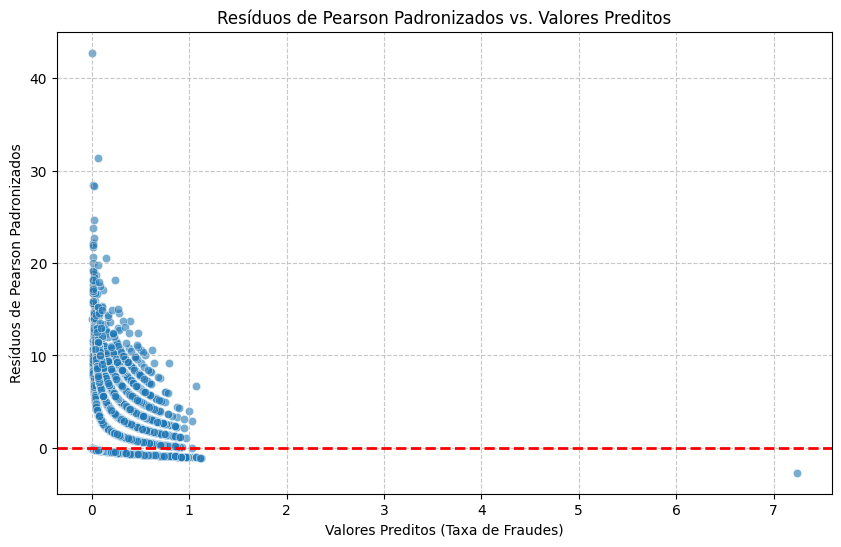

In [22]:
pearson_residuals = modelo_poisson_stepswise.resid_pearson
fitted_values = modelo_poisson_stepswise.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Valores Preditos (Taxa de Fraudes)")
plt.ylabel("Resíduos de Pearson Padronizados")
plt.title("Resíduos de Pearson Padronizados vs. Valores Preditos")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [23]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,-4.1217***,1.6058,1.8660*
,(0.0319),(1.2832),(1.1186)
transactions,0.0170***,0.0186***,
,(0.0002),(0.0003),
mean_amount,,0.0067***,
,,(0.0007),
std_amount,,0.0005,
,,(0.0004),
mean_current_age,,0.0155**,
,,(0.0069),


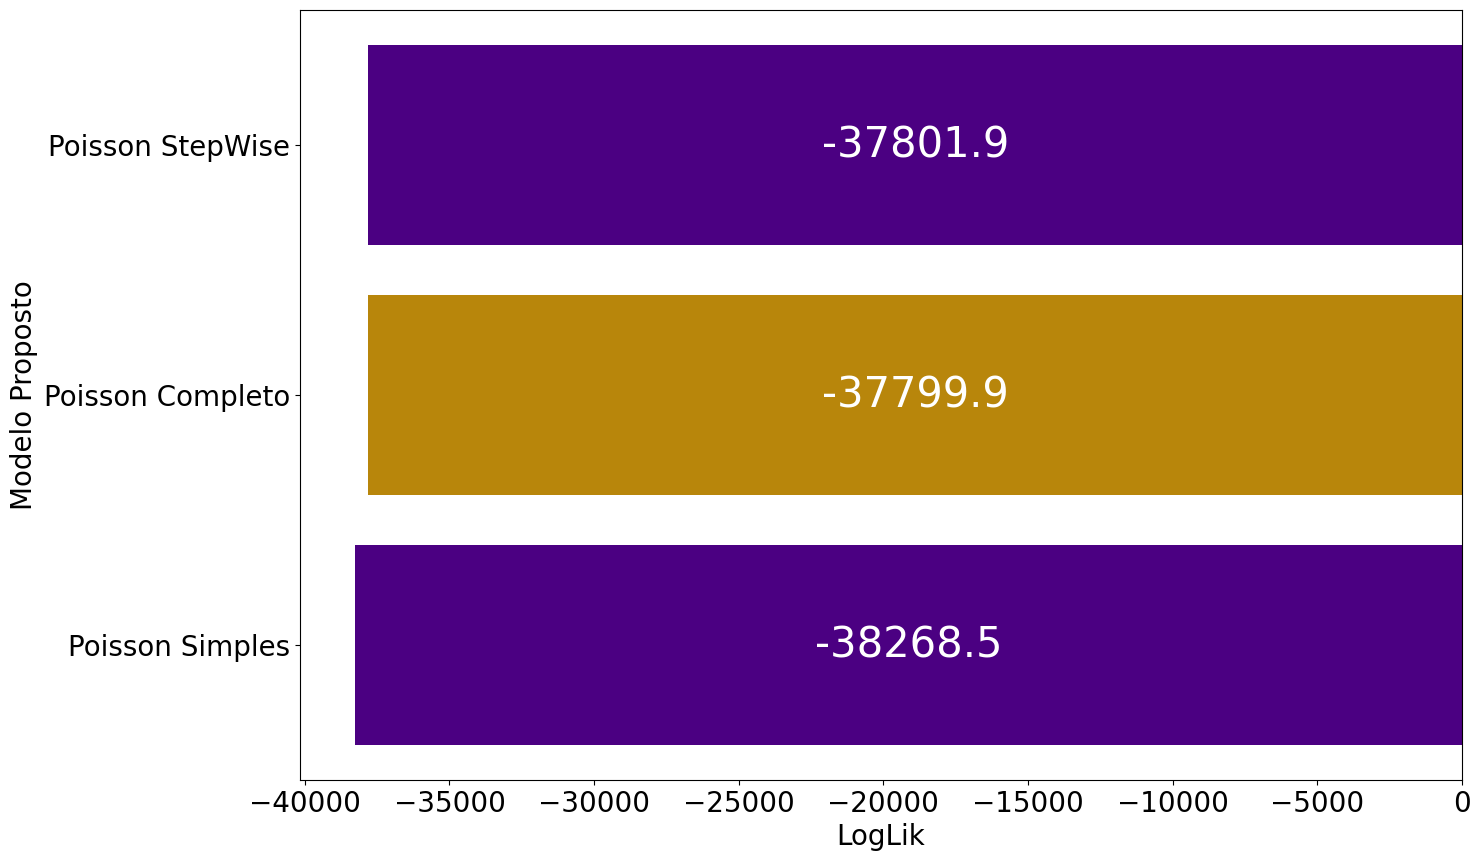

In [24]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [25]:
modelo_binomialneg_simples = smf.glm(formula='frauds ~ transactions', data=df, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86151
Model:                            GLM   Df Residuals:                    86149
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34650.
Date:                Tue, 27 May 2025   Deviance:                       43251.
Time:                        22:32:42   Pearson chi2:                 1.39e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1001
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.1303      0.033   -123.695      0.000      -4.196      -4.065
transactions     0.0171      0.000     80.792      0.000       0.017       0.017
================================================================================
"""

In [26]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=df, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86104
Model Family:        NegativeBinomial   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34275.
Date:                Tue, 27 May 2025   Deviance:                       42505.
Time:                        22:32:47   Pearson chi2:                 1.45e+05
No. Iterations:                    25   Pseudo R-squ. (CS):             0.1078
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.8406      1.419      1.297      0.195      -0.941       4.623
transactions                                0.0187      0.000     59.072      0.000       0.018       0.019
mean_amount                                 0.0123      0.001     12.546      0.000       0.010       0.014
std_amount                               -9.39e-05      0.000     -0.223      0.824      -0.001       0.001
mean_current_age                            0.0246      0.008      3.258      0.001       0.010       0.039
std_current_age                            -0.0427      0.010     -4.228      0.000      -0.062      -0.023
mean_total_debt                         -3.403e-06   2.15e-06     -1.581      0.114   -7.62e-06    8.15e-07
mean_credit_score                          -0.0117      0.002     -7.447      0.000      -0.015      -0.009
std_credit_score                           -0.0080      0.002     -4.245      0.000      -0.012      -0.004
mean_num_credit_cards                       0.3174      0.074      4.309      0.000       0.173       0.462
std_num_credit_cards                       -0.2023      0.107     -1.891      0.059      -0.412       0.007
skew_num_credit_cards                       0.3857      0.072      5.344      0.000       0.244       0.527
kurtosis_num_credit_cards                  -0.0188      0.037     -0.512      0.608      -0.091       0.053
mean_credit_limit                         4.13e-06    9.3e-06      0.444      0.657   -1.41e-05    2.24e-05
gender_female                               1.3345      0.190      7.033      0.000       0.963       1.706
card_brand_amex                            -1.5176      0.400     -3.794      0.000      -2.302      -0.734
card_brand_discover                         1.7042      0.595      2.865      0.004       0.539       2.870
card_type_debit_prepaid                     1.2136      0.393      3.089      0.002       0.444       1.984
has_chip_no                                 0.1895      0.320      0.592      0.554      -0.438       0.817
category_food_beverage                      0.1697      0.735      0.231      0.817      -1.270       1.609
category_retail_general_department          2.7084      0.772      3.509      0.000       1.196       4.221
category_financial_insurance                0.4498      0.853      0.527      0.598      -1.222       2.122
category_retail_specialty                  -0.8875      0.859     -1.033      0.302      -2.572       0.797
category_transportation_logistics          -0.8033      0.742     -1.083      0.279      -2.257       0.650
category_government_utilities              -3.6372      0.887     -4.101      0.000      -5.376      -1.899
category_arts_entertainment_recreation     -3.5107      0.9

In [27]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('mean_current_age') + Q('std_current_age') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_food_beverage') + Q('category_retail_general_department') + Q('category_financial_insurance') + Q('category_retail_specialty') + Q('category_transportation_logistics') + Q('category_government_utilities') + Q('category_arts_entertainment_recreation') + Q('category_technology_telecommunications') + Q('category_health_medical') + Q('category_professional_business_services') + Q('category_travel_hospitality') + Q('category_retail_clothing_accessories') + Q('category_sports_recreation') + Q(

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86115
Model Family:        NegativeBinomial   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34279.
Date:                Tue, 27 May 2025   Deviance:                       42513.
Time:                        22:33:29   Pearson chi2:                 1.45e+05
No. Iterations:                    21   Pseudo R-squ. (CS):             0.1077
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        1.6610      1.181      1.407      0.159      -0.653       3.975
Q('transactions')                                0.0187      0.000     62.332      0.000       0.018       0.019
Q('mean_amount')                                 0.0124      0.001     17.130      0.000       0.011       0.014
Q('mean_current_age')                            0.0292      0.007      4.124      0.000       0.015       0.043
Q('std_current_age')                            -0.0411      0.010     -4.104      0.000      -0.061      -0.021
Q('mean_credit_score')                          -0.0116      0.002     -7.406      0.000      -0.015      -0.009
Q('std_credit_score')                           -0.0084      0.002     -4.492      0.000      -0.012      -0.005
Q('mean_num_credit_cards')                       0.3138      0.072      4.334      0.000       0.172       0.456
Q('std_num_credit_cards')                       -0.2138      0.095     -2.257      0.024      -0.399      -0.028
Q('skew_num_credit_cards')                       0.3710      0.050      7.392      0.000       0.273       0.469
Q('gender_female')                               1.3651      0.189      7.225      0.000       0.995       1.735
Q('card_brand_amex')                            -1.5218      0.396     -3.846      0.000      -2.297      -0.746
Q('card_brand_discover')                         1.7108      0.593      2.885      0.004       0.549       2.873
Q('card_type_debit_prepaid')                     1.1073      0.363      3.051      0.002       0.396       1.819
Q('category_retail_general_department')          2.5295      0.271      9.346      0.000       1.999       3.060
Q('category_retail_specialty')                  -1.1733      0.549     -2.137      0.033      -2.249      -0.097
Q('category_transportation_logistics')          -1.0363      0.197     -5.269      0.000      -1.422      -0.651
Q('category_government_utilities')              -3.7981      0.562     -6.755      0.000      -4.900      -2.696
Q('category_arts_entertainment_recreation')     -3.7639      0.574     -6.555      0.000      -4.889      -2.639
Q('category_technology_telecommunications')     -0.9697      0.466     -2.079      0.038      -1.884      -0.056
Q('category_health_medical')                    -2.3168      0.384     -6.033      0.000      -3.069      -1.564
Q('category_professional_business_services')    -3.0402      1.109     -2.742      0.006      -5.213      -0.867
Q('category_travel_hospitality')                 2.0805      0.996      2.088      0.037       0.128       4.033
Q('category_retail_clothing_accessories')        4.6717      1.040      4.490      0.000       2.633       6.711
Q('category_construction_contrac

In [28]:
lrtest([modelo_poisson_stepswise, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): 7044.93
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


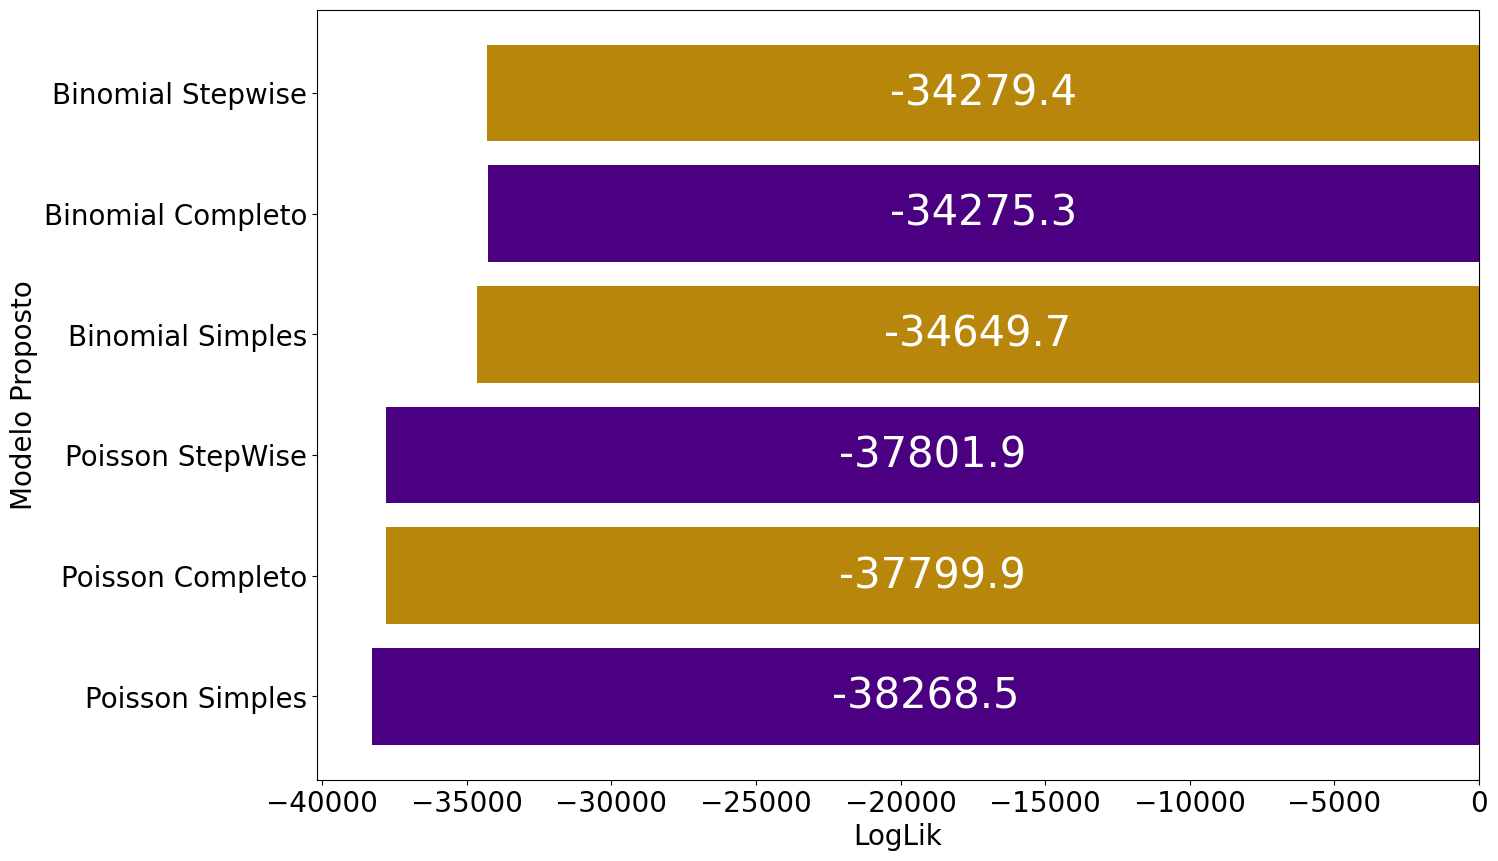

In [29]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [30]:
y = df['frauds'].copy()
X1 = df['transactions'].copy()
X1 = sm.add_constant(X1)

In [31]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zip_simples.summary()

         Current function value: 0.385232
         Iterations: 35
         Function evaluations: 67
         Gradient evaluations: 67


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86151
Model:             ZeroInflatedPoisson   Df Residuals:                    86149
Method:                            MLE   Df Model:                            1
Date:                 Tue, 27 May 2025   Pseudo R-squ.:                 0.05206
Time:                         22:33:36   Log-Likelihood:                -33188.
converged:                       False   LL-Null:                       -35011.
Covariance Type:             nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            0.7036      0.058     12.039      0.000       0.589       0.818
inflate_transactions     0.0016      0.000      4.583      0.000       0.001       0.002
const                   -3.8343      0.042    -90.786      0.000      -3.917      -3.752
transactions             0.0228      0.000     88.844      0.000       0.022       0.023
========================================================================================
"""

In [32]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 0.444203
         Iterations 6
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -42.119
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [33]:
df.columns

Index(['date_window', 'transactions', 'frauds', 'mean_amount', 'std_amount',
       'mean_current_age', 'std_current_age', 'mean_total_debt',
       'mean_credit_score', 'std_credit_score', 'mean_num_credit_cards',
       'std_num_credit_cards', 'skew_num_credit_cards',
       'kurtosis_num_credit_cards', 'mean_credit_limit', 'gender_female',
       'card_brand_amex', 'card_brand_discover', 'card_type_debit_prepaid',
       'has_chip_no', 'category_food_beverage',
       'category_retail_general_department', 'category_financial_insurance',
       'category_retail_specialty', 'category_transportation_logistics',
       'category_government_utilities',
       'category_arts_entertainment_recreation',
       'category_technology_telecommunications', 'category_health_medical',
       'category_professional_business_services',
       'category_travel_hospitality', 'category_retail_clothing_accessories',
       'category_sports_recreation', 'category_construction_contractors',
       'catego

In [34]:
exclude_columns = [column for column in df.columns if 'std_' in column]
exclude_columns.extend([column for column in df.columns if 'skew_' in column])
exclude_columns.extend([column for column in df.columns if 'kurtosis_' in column])

In [35]:
X = df.drop(columns=['date_window', 'frauds']).drop(columns=exclude_columns).copy(deep=True)

In [36]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X)
X = pd.DataFrame(X_scaler, columns=X.columns)

In [37]:
X = sm.add_constant(X)

In [38]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X, exog_infl=X, inflation='logit').fit()
modelo_zip_complete.summary()

         Current function value: 0.372594
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86151
Model:             ZeroInflatedPoisson   Df Residuals:                    86121
Method:                            MLE   Df Model:                           29
Date:                 Tue, 27 May 2025   Pseudo R-squ.:                 0.08316
Time:                         22:33:58   Log-Likelihood:                -32099.
converged:                       False   LL-Null:                       -35011.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.6639      0.019     85.538      0.000       1.626       1.702
inflate_transactions                               -0.3921      0.026    -15.008      0.000      -0.443      -0.341
inflate_mean_amount                                -0.3173      0.029    -10.990      0.000      -0.374      -0.261
inflate_mean_current_age                           -0.0632      0.022     -2.817      0.005      -0.107      -0.019
inflate_mean_total_debt                             0.0143      0.020      0.720      0.471      -0.025       0.053
inflate_mean_credit_score                          -0.0854      0.019     -4.439      0.000      -0.123      -0.048
inflate_mean_num_credit_cards                      -0.0987      0.022     -4.403      0.000      -0.143      -0.055
inflate_mean_credit_limit                          -0.0704      0.021     -3.416      0.001      -0.111      -0.030
inflate_gender_female                              -0.1986      0.020     -9.820      0.000      -0.238      -0.159
inflate_card_brand_amex                            -0.0060      0.019     -0.311      0.756      -0.044       0.032
inflate_card_brand_discover                        -0.0164      0.019     -0.857      0.392      -0.054       0.021
inflate_card_type_debit_prepaid                    -0.0973      0.021     -4.720      0.000      -0.138      -0.057
inflate_has_chip_no                                 0.0140      0.018      0.758      0.448      -0.022       0.050
inflate_category_food_beverage                      0.0727      0.096      0.755      0.450      -0.116       0.261
inflate_category_retail_general_department          0.0399      0.054      0.732      0.464      -0.067       0.147
inflate_category_financial_insurance                0.0663      0.033      2.029      0.042       0.002       0.130
inflate_category_retail_specialty                   0.2965      0.032      9.271      0.000       0.234       0.359
inflate_category_transportation_logistics           0.0194      0.081      0.241      0.810      -0.138       0.177
inflate_category_government_utilities               0.0251      0.040      0.628      0.530      -0.053       0.103
inflate_category_arts_entertainment_recreation      0.3213      0.035      9.079      0.000       0.252       0.391
inflate_category_technology_telecommunications     -0.0909      0.052     -1.748      0.080      -0.193       0.011
inflate_category_health_medical                     0.1539      0.040      3.807      0.000       0.075       0.233
inflate_category_professional_business_services     0.0233      0.028      0.819      0.413      -0.032       0.079
inflate_category_travel_hospitality                 0.0881      0.029      3.041      0.002       0.031       0.145
inflate_category_retail_clothing_accessories       -0.0153      0.023     -0.680      0.497      -0.

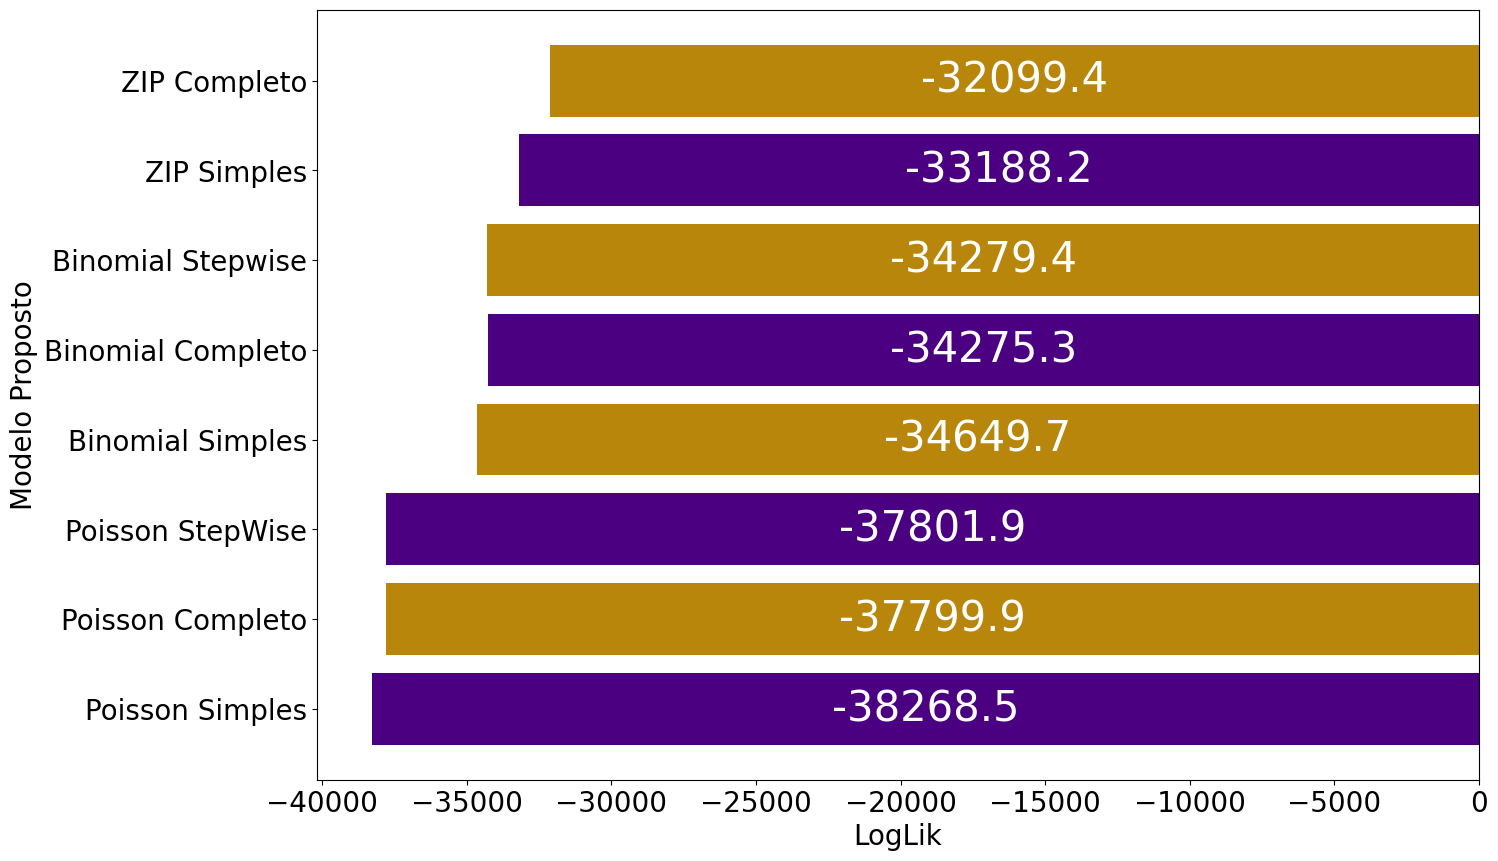

In [39]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [40]:
y = df['frauds'].copy()
X = df.drop(columns=['date_window', 'frauds']).drop(columns=exclude_columns)

In [41]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X)

X = pd.DataFrame(X_scaler, columns=X.columns)
X['frauds'] = y
X

,transactions,mean_amount,mean_current_age,mean_total_debt,mean_credit_score,mean_num_credit_cards,mean_credit_limit,gender_female,card_brand_amex,card_brand_discover,...,category_health_medical,category_professional_business_services,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services,frauds
0,-1.243958,-1.328104,-0.189410,0.557653,2.186942,1.826253,-0.125431,-1.228228,-0.694338,-1.096842,...,-1.787991,-0.518463,-0.349381,-0.623120,-0.460915,-0.139341,-1.066960,-0.51915,-0.778979,0
1,-1.308179,0.099300,0.485967,0.124347,2.422538,1.645986,3.486455,2.726018,0.706242,-1.096842,...,-1.787991,-0.518463,-0.349381,-0.623120,-0.460915,-0.139341,-1.066960,-0.51915,-0.778979,0
2,-1.260013,-0.323037,-0.944592,2.199524,1.242126,-1.908265,-0.204175,-1.483341,0.426126,-1.096842,...,-0.687413,1.894354,2.071605,2.369584,-0.460915,-0.139341,-1.066960,-0.51915,-0.778979,0
3,-1.324234,-0.738361,-0.655151,-1.551148,-0.302758,-0.762572,-0.053492,0.685117,0.986358,-1.096842,...,-0.412268,-0.518463,-0.349381,3.117760,-0.460915,-0.139341,-1.066960,-0.51915,-0.778979,0
4,-1.404509,-0.542016,0.387798,-0.446279,-3.730173,1.206587,0.994716,1.322899,-0.134106,-1.096842,...,-0.137124,-0.518463,-0.349381,-0.623120,5.333800,-0.139341,-1.066960,-0.51915,-0.778979,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86146,-0.296709,0.110519,-0.729857,0.574351,1.358276,-0.644633,0.479955,-1.355784,0.146010,1.430952,...,0.138021,0.084742,0.255866,-0.623120,0.504871,-0.139341,-0.690334,0.25045,1.125440,0
86147,-0.698086,0.017114,-1.356603,-0.069639,-0.627585,0.025091,-1.039712,0.174892,1.546590,0.167055,...,-0.412268,0.687946,1.466358,0.873232,-0.460915,-0.139341,-1.066960,-0.51915,1.125440,0
86148,-0.425149,0.785582,-0.653233,0.597638,-1.387467,-0.669578,1.066538,-0.080221,0.706242,0.588354,...,-0.137124,-0.518463,-0.349381,0.125056,-0.460915,-0.139341,0.816169,-0.13435,0.173230,0
86149,-0.633865,0.699257,-0.442870,0.278652,-0.740948,0.065370,0.617493,-0.845559,0.706242,-0.254244,...,-0.137124,0.687946,0.861112,-0.623120,-0.460915,-0.139341,-1.066960,0.25045,1.125440,0


Executando otimização para ZIP...
[ZIP Optimizer] Seed de aleatoriedade definida para: 42
[ZIP Optimizer] Número total de features disponíveis: 29
[Model Evaluator - Init] Inicializado para variável dependente: 'frauds'.
[ZIP Optimizer] Avaliador de modelo Zero-Inflated inicializado.
[ZIP Optimizer] 'FitnessMin' criado para minimização.
[ZIP Optimizer] 'Individual' criado como lista com FitnessMin.
[ZIP Optimizer] Operadores genéticos (mate, mutate, select) registrados.
[ZIP Optimizer] Estatísticas para o logbook registradas.
[ZIP Optimizer] Hall of Fame (tamanho 1) inicializado.
[ZIP Optimizer] Componentes DEAP configurados.

--- Iniciando otimização para modelo ZIP ---
[ZIP Optimizer] População inicial gerada com 8 indivíduos.
[ZIP Optimizer] Iniciando Pool de 8 processos para avaliação paralela.
[ZIP Optimizer] Avaliando 8 indivíduos da geração inicial (0) em paralelo...
[ZIP Optimizer] Avaliação da geração 0 concluída.
gen	nevals	avg     	std     	min     	max
0  	8     	0.764583	0

Evoluindo ZIP (Gen: 30/30, Min Fit: 0.45, Avg Fit: 0.46): 100%|██████████| 30/30 [19:25<00:00, 38.87s/it]


[ZIP Optimizer] Otimização concluída. Melhor fitness encontrado: 0.4500
[ZIP Optimizer] Treinando modelo final com o melhor indivíduo encontrado...
[ZIP Optimizer] Features do melhor indivíduo para Contagem: ['mean_amount', 'mean_current_age', 'mean_credit_score', 'mean_num_credit_cards', 'card_brand_amex', 'card_type_debit_prepaid', 'has_chip_no', 'category_food_beverage', 'category_retail_general_department', 'category_transportation_logistics', 'category_government_utilities', 'category_arts_entertainment_recreation', 'category_technology_telecommunications', 'category_travel_hospitality', 'category_retail_clothing_accessories', 'category_sports_recreation', 'category_construction_contractors', 'category_personal_services']
[ZIP Optimizer] Features do melhor indivíduo para Zero-Inflated: ['mean_amount', 'mean_total_debt', 'mean_num_credit_cards', 'gender_female', 'card_brand_discover', 'category_food_beverage', 'category_retail_general_department', 'category_financial_insurance', 'c

Não utilizados

mean_per_capita_income

mean_total_debt

mean_credit_score

mean_num_credit_cards

mean_credit_limit

use_chip_swipe_transaction

gender_female

card_brand_amex

card_brand_discover

card_type_credit

card_type_debit_prepaid

has_chip_no

online_sales_no

'category_financial_insurance'

'category_retail_general_department'

, 'category_retail_specialty'

, 'category_government_utilities'

, 'category_technology_telecommunications'

, 'category_arts_entertainment_recreation'

, 'category_travel_hospitality'

, 'category_professional_business_services'

 'category_health_medical'

 , 'category_retail_clothing_accessories'

 , 'category_sports_recreation'

 , 'category_construction_contractors'

 , 'category_retail_home_garden'

 , 'category_manufacturing_industrial'

In [48]:
# y = df['frauds'].copy()
# X1 = df[['transactions', 'mean_amount', 'mean_current_age', 'category_transportation_logistics', 'category_food_beverage']].copy()
# X1 = sm.add_constant(X1)

# X2 = df[['transactions']].copy()
# X2 = sm.add_constant(X2)

modelo_zip_stepwise = zip_optimizer.final_model_results
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86151
Model:             ZeroInflatedPoisson   Df Residuals:                    86132
Method:                            MLE   Df Model:                           18
Date:                 Tue, 27 May 2025   Pseudo R-squ.:                 0.04149
Time:                         23:04:56   Log-Likelihood:                -33558.
converged:                       False   LL-Null:                       -35011.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.8793      0.015    125.535      0.000       1.850       1.909
inflate_mean_amount                                 0.1559      0.021      7.343      0.000       0.114       0.197
inflate_mean_total_debt                             0.0388      0.015      2.567      0.010       0.009       0.068
inflate_mean_num_credit_cards                      -0.1008      0.016     -6.311      0.000      -0.132      -0.069
inflate_gender_female                              -0.1151      0.016     -7.256      0.000      -0.146      -0.084
inflate_card_brand_discover                         0.0088      0.016      0.565      0.572      -0.022       0.039
inflate_category_food_beverage                      0.0712      0.020      3.639      0.000       0.033       0.109
inflate_category_retail_general_department          0.0717      0.018      3.969      0.000       0.036       0.107
inflate_category_financial_insurance               -0.0556      0.016     -3.517      0.000      -0.087      -0.025
inflate_category_retail_specialty                   0.1603      0.017      9.210      0.000       0.126       0.194
inflate_category_government_utilities               0.0593      0.020      2.903      0.004       0.019       0.099
inflate_category_arts_entertainment_recreation      0.1229      0.019      6.415      0.000       0.085       0.160
inflate_category_health_medical                     0.0089      0.017      0.540      0.589      -0.023       0.041
inflate_category_professional_business_services     0.1577      0.020      8.056      0.000       0.119       0.196
inflate_category_travel_hospitality                 0.1285      0.020      6.450      0.000       0.089       0.168
inflate_category_sports_recreation                  0.0669      0.016      4.117      0.000       0.035       0.099
inflate_category_manufacturing_industrial           0.1232      0.019      6.385      0.000       0.085       0.161
inflate_category_personal_services                 -0.2596      0.013    -19.290      0.000      -0.286      -0.233
const                                              -0.1324      0.014     -9.267      0.000      -0.160      -0.104
mean_amount                                        -0.0079      0.021     -0.374      0.709      -0.049       0.033
mean_current_age                                    0.1265      0.016      7.775      0.000       0.095       0.158
mean_credit_score                                  -0.0205      0.015     -1.381      0.167      -0.050       0.009
mean_num_credit_cards                              -0.1015      0.018     -5.765      0.000      -0.136      -0.067
card_brand_amex                                    -0.0433      0.015     -2.859      0.004      -0.073      -0.014
card_type_debit_prepaid                             0.0542      0.015      3.595      0.000       0.

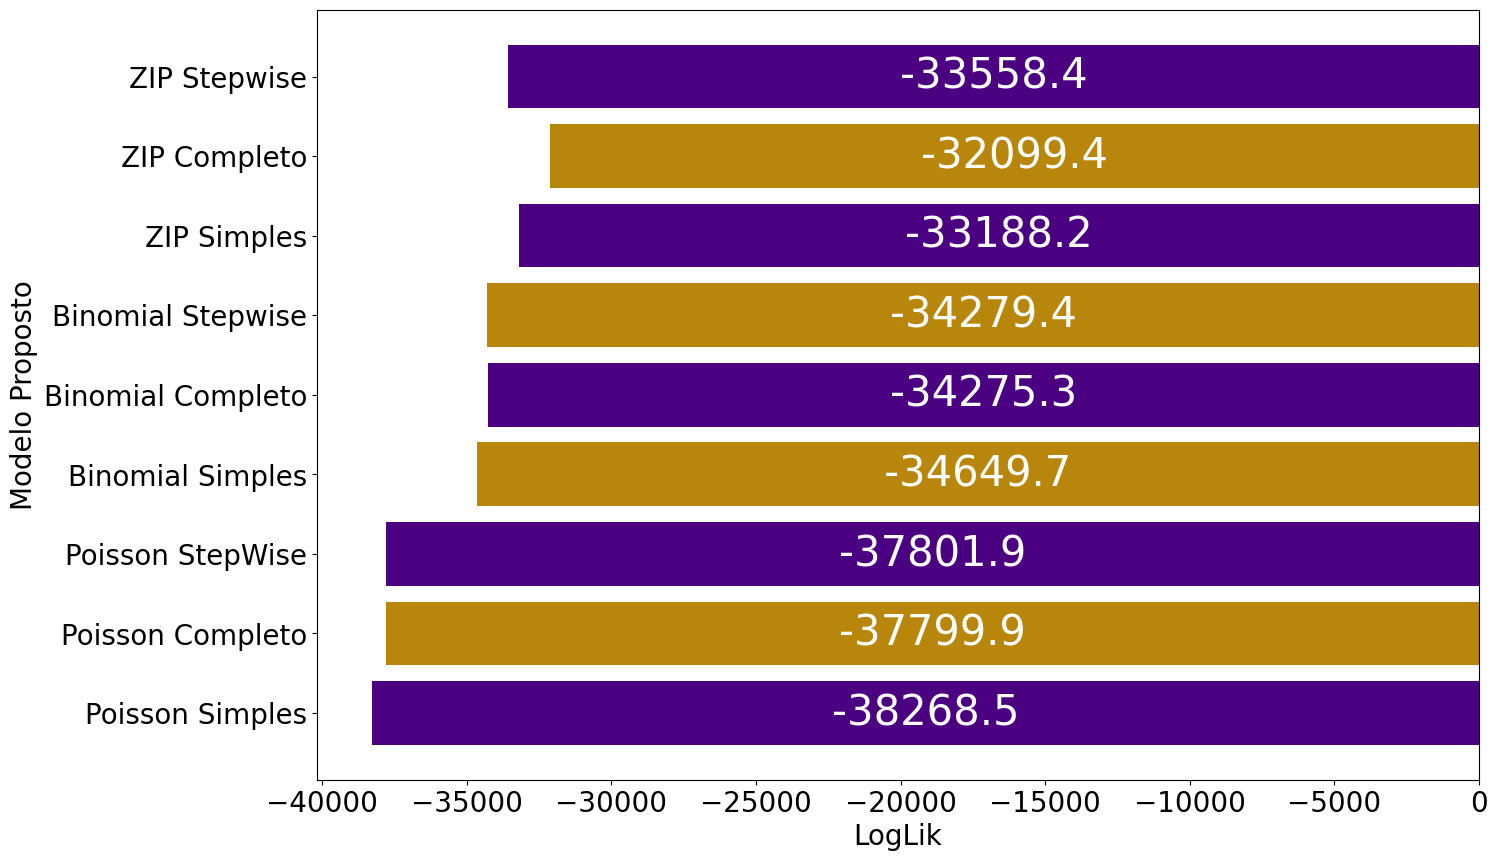

In [49]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [50]:
y = X['frauds'].copy()
X1 = X['transactions'].copy()

X1 = sm.add_constant(X1)

In [51]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_simples.summary()

         Current function value: 0.374623
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86151
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86149
Method:                                      MLE   Df Model:                            1
Date:                           Tue, 27 May 2025   Pseudo R-squ.:                 0.07373
Time:                                   23:05:31   Log-Likelihood:                -32274.
converged:                                 False   LL-Null:                       -34843.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const           -0.5585      0.143     -3.900      0.000      -0.839      -0.278
inflate_transactions    -1.6467      0.083    -19.888      0.000      -1.809      -1.484
const                   -1.7149      0.050    -34.406      0.000      -1.813      -1.617
transactions             0.5560      0.033     16.658      0.000       0.491       0.621
alpha                    5.2227      0.220     23.745      0.000       4.792       5.654
========================================================================================
"""

In [52]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 0.376742
         Iterations: 19
         Function evaluations: 29
         Gradient evaluations: 29
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -10.005
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [53]:
y = X['frauds']
X1 = X.drop(columns=['frauds']).copy()
X1 = sm.add_constant(X1)

modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_complete.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.403150
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86151
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86121
Method:                                      MLE   Df Model:                           29
Date:                           Tue, 27 May 2025   Pseudo R-squ.:                0.003196
Time:                                   23:11:07   Log-Likelihood:                -34732.
converged:                                 False   LL-Null:                       -34843.
Covariance Type:                       nonrobust   LLR p-value:                 9.017e-32
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                      -5.6164        nan        nan        nan         nan         nan
inflate_transactions                               -2.6564        nan        nan        nan         nan         nan
inflate_mean_amount                                 0.3755        nan        nan        nan         nan         nan
inflate_mean_current_age                           -0.4648        nan        nan        nan         nan         nan
inflate_mean_total_debt                             0.0866        nan        nan        nan         nan         nan
inflate_mean_credit_score                           0.2328        nan        nan        nan         nan         nan
inflate_mean_num_credit_cards                      -0.1158        nan        nan        nan         nan         nan
inflate_mean_credit_limit                           0.1363        nan        nan        nan         nan         nan
inflate_gender_female                              -0.2089        nan        nan        nan         nan         nan
inflate_card_brand_amex                             0.0763        nan        nan        nan         nan         nan
inflate_card_brand_discover                         0.0393        nan        nan        nan         nan         nan
inflate_card_type_debit_prepaid                    -0.1416        nan        nan        nan         nan         nan
inflate_has_chip_no                                -0.1560        nan        nan        nan         nan         nan
inflate_category_food_beverage                     -0.0427        nan        nan        nan         nan         nan
inflate_category_retail_general_department         -0.0518        nan        nan        nan         nan         nan
inflate_category_financial_insurance                0.1460        nan        nan        nan         nan         nan
inflate_category_retail_specialty                  -0.3404        nan        nan        nan         nan         nan
inflate_category_transportation_logistics          -0.3392        nan        nan        nan         nan         nan
inflate_category_government_utilities               0.1386        nan        nan        nan         nan         nan
inflate_category_arts_entertainment_recreation      0.5994        nan        nan        nan         nan         nan
inflate_category_technology_telecommunications      0.7578        nan        nan        nan         nan         nan
inflate_category_health_medical                    -0.2995        nan        nan        nan         nan         nan
inflate_category_professional_business_services     0.0695        nan        nan        nan         nan         nan
inflate_category_travel_hospitality                -0.1058        nan        nan        nan         nan         nan
inflate_ca

In [54]:
dispersion = df.drop(columns='date_window').agg(['mean', 'var']).T.assign(overdispersion=lambda x: x['var'] > x['mean'], underdispersion=lambda x: x['var'] < x['mean'])
dispersion.head()

,mean,var,overdispersion,underdispersion
transactions,103.480668,3879.538358,True,False
frauds,0.154752,0.352906,True,False
mean_amount,46.634533,291.377021,True,False
std_amount,79.750805,1232.055809,True,False
mean_current_age,53.812155,5.095111,False,True


In [55]:
dispersion.query('overdispersion == False').index.to_list()

['mean_current_age',
 'std_current_age',
 'mean_credit_score',
 'mean_num_credit_cards',
 'std_num_credit_cards',
 'skew_num_credit_cards',
 'gender_female',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit_prepaid',
 'has_chip_no',
 'category_food_beverage',
 'category_retail_general_department',
 'category_financial_insurance',
 'category_retail_specialty',
 'category_transportation_logistics',
 'category_government_utilities',
 'category_arts_entertainment_recreation',
 'category_technology_telecommunications',
 'category_health_medical',
 'category_professional_business_services',
 'category_travel_hospitality',
 'category_retail_clothing_accessories',
 'category_sports_recreation',
 'category_construction_contractors',
 'category_retail_home_garden',
 'category_manufacturing_industrial',
 'category_personal_services']

In [56]:
df_standard = df.copy()
y = df_standard['frauds']
X = df_standard.drop(columns=['frauds', 'date_window'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,transactions,mean_amount,std_amount,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,...,category_technology_telecommunications,category_health_medical,category_professional_business_services,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,-1.243958,-1.328104,-1.179430,-0.189410,-0.494798,0.557653,2.186942,-0.490035,1.826253,-0.983778,...,-0.931184,-1.787991,-0.518463,-0.349381,-0.623120,-0.460915,-0.139341,-1.06696,-0.51915,-0.778979
1,-1.308179,0.099300,-0.329318,0.485967,-1.129803,0.124347,2.422538,-0.936719,1.645986,0.590884,...,0.186902,-1.787991,-0.518463,-0.349381,-0.623120,-0.460915,-0.139341,-1.06696,-0.51915,-0.778979
2,-1.260013,-0.323037,-0.797890,-0.944592,1.105847,2.199524,1.242126,-1.343285,-1.908265,-1.088697,...,-0.931184,-0.687413,1.894354,2.071605,2.369584,-0.460915,-0.139341,-1.06696,-0.51915,-0.778979
3,-1.324234,-0.738361,-0.455169,-0.655151,0.398207,-1.551148,-0.302758,0.065440,-0.762572,-1.979733,...,3.317544,-0.412268,-0.518463,-0.349381,3.117760,-0.460915,-0.139341,-1.06696,-0.51915,-0.778979
4,-1.404509,-0.542016,-0.979444,0.387798,-1.195665,-0.446279,-3.730173,1.188493,1.206587,0.882790,...,-0.931184,-0.137124,-0.518463,-0.349381,-0.623120,5.333800,-0.139341,-1.06696,-0.51915,-0.778979


In [58]:
X1 = X_scaled[['transactions', 'mean_credit_score',]].copy()
X1 = sm.add_constant(X1)

X2 = X_scaled[['transactions', 'mean_amount', 'mean_current_age', 'mean_credit_score']].copy()
X2 = sm.add_constant(X1)


modelo_zinb_stepwise = ZeroInflatedNegativeBinomialP(y, X1, inflation='logit').fit(max_iter=200)
modelo_zinb_stepwise.summary()

         Current function value: 0.376554
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86151
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86148
Method:                                      MLE   Df Model:                            2
Date:                           Tue, 27 May 2025   Pseudo R-squ.:                 0.06896
Time:                                   23:11:45   Log-Likelihood:                -32441.
converged:                                 False   LL-Null:                       -34843.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_const        -1.8986        nan        nan        nan         nan         nan
const                -2.2260        nan        nan        nan         nan         nan
transactions          1.0718        nan        nan        nan         nan         nan
mean_credit_score    -0.0766        nan        nan        nan         nan         nan
alpha                 4.9855        nan        nan        nan         nan         nan
=====================================================================================
"""

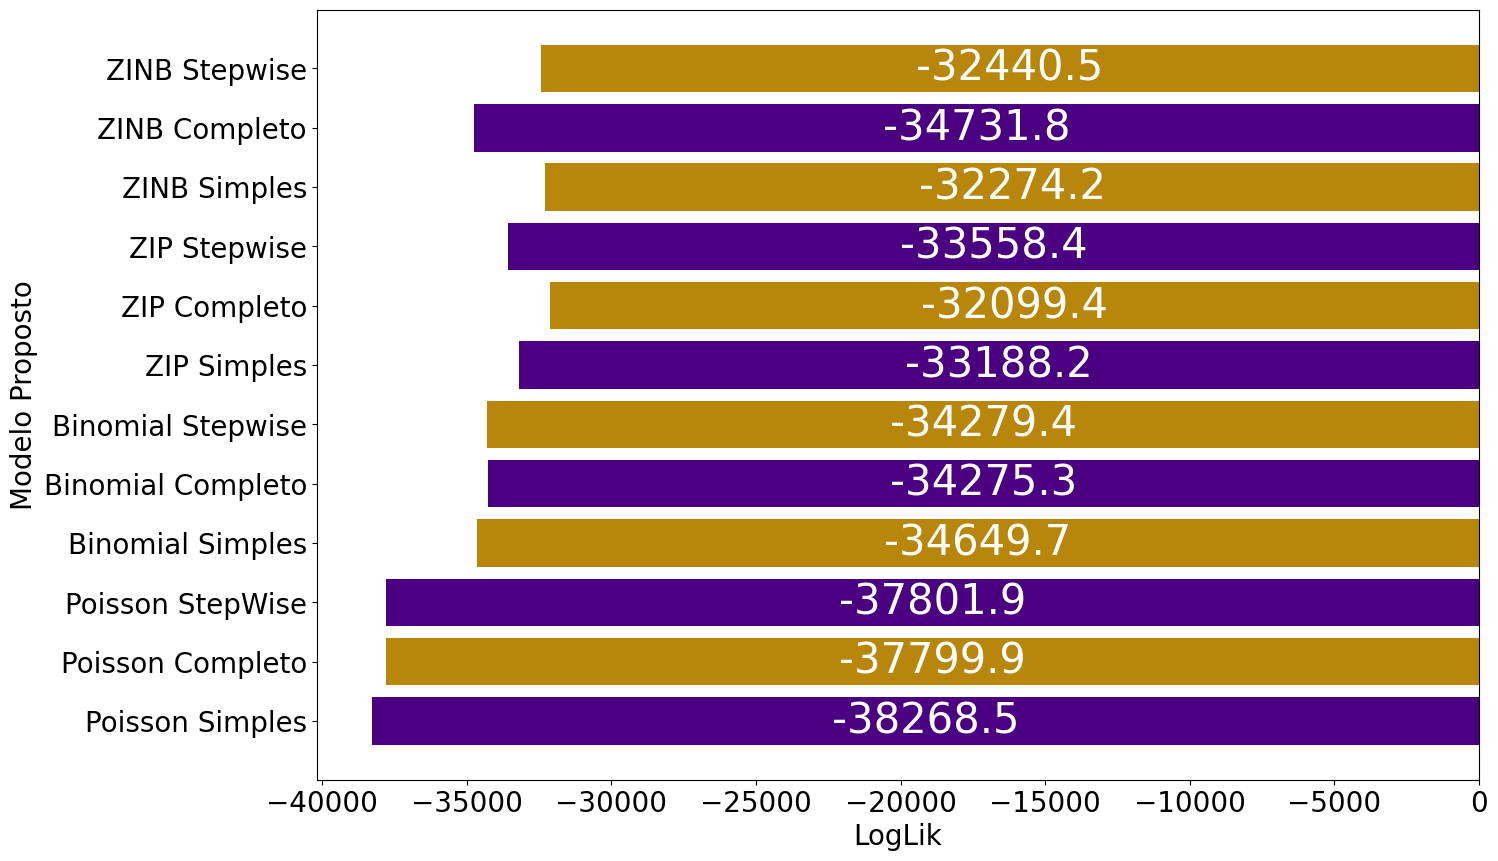

In [59]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_stepwise.llf
      ]
})